# Determining tortuosity using geometric domain decomposition

Import necessary packages and functions

In [1]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
ps.visualization.set_mpl_style()

C:\Users\jeff\anaconda3\envs\dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate test image

(-0.5, 162.5, 130.5, -0.5)

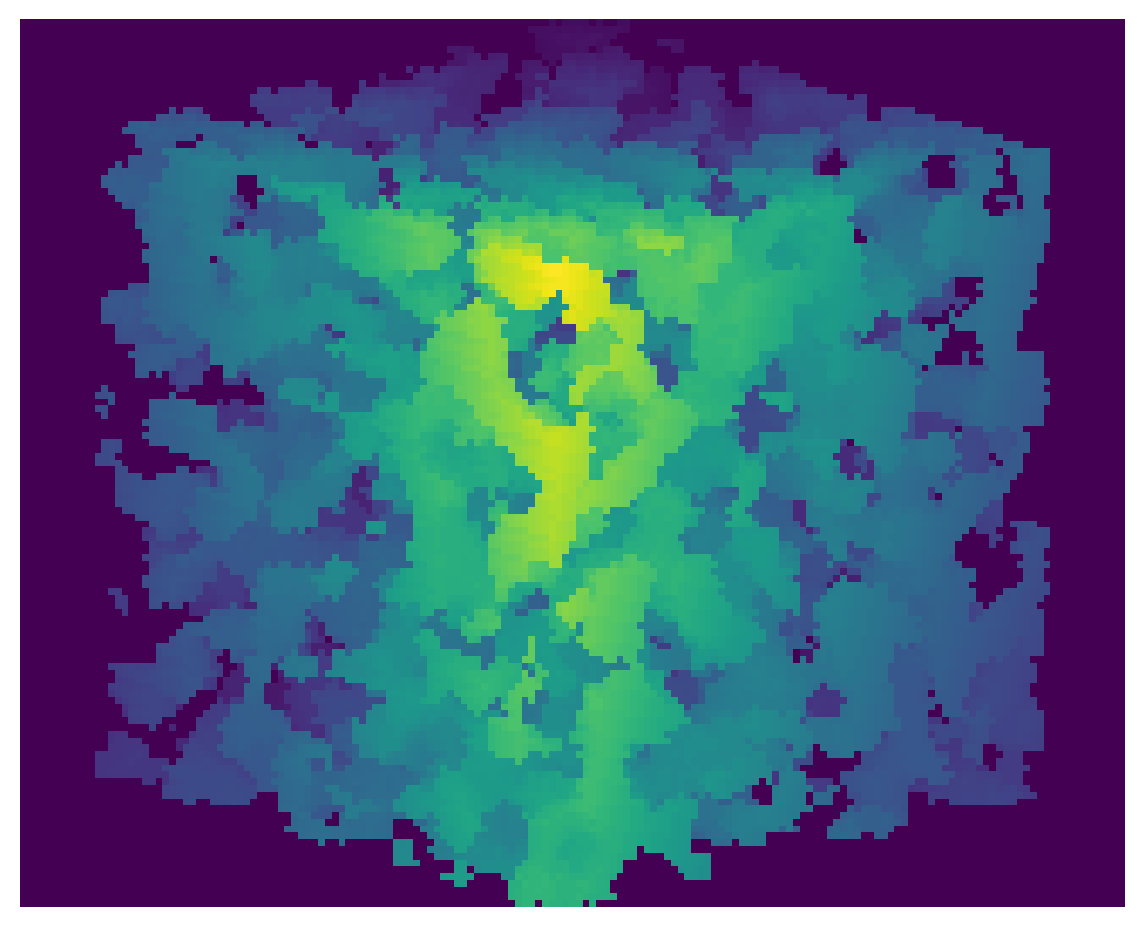

In [2]:
# im = ps.generators.fractal_noise(shape=[100,100,100], seed=1)<0.8
np.random.seed(1)
im = ps.generators.blobs(shape=[100,100,100], porosity=0.7)
plt.imshow(ps.visualization.show_3D(im))
plt.axis('off')

## Run the function on the image

In [3]:
from porespy.beta import tortuosity_gdd
out = tortuosity_gdd(im, scale_factor=3)
print(out.tau)

Max distance transform found: 9.164999961853027
[3 3 3] <= [3,3,3], using 33 as chunk size.
[1.3940749221735982, 1.4540195658662034, 1.4319709358246486]


The first three results in the returned object are the tortuosity values in the x, y, and z-direction respectively. The following results are time stamps on  However, there is a more useful form of this function.

In [4]:
from porespy.beta import chunks_to_dataframe
out2 = chunks_to_dataframe(im, scale_factor=3)
out2.iloc[:10,:]

Max distance transform found: 9.164999961853027
[3 3 3] <= [3,3,3], using 33 as chunk size.


,Throat Number,Tortuosity,Diffusive Conductance,Porosity
0,0,1.242083,19.555253,0.736038
1,1,1.404705,15.727675,0.669477
2,2,1.268947,19.731037,0.758717
3,3,1.520043,15.566115,0.717005
4,4,1.350561,18.242258,0.746584
5,5,1.405354,15.285239,0.650945
6,6,1.634790,13.765760,0.681943
7,7,1.388642,17.317457,0.728720
8,8,1.528631,14.278425,0.661407
9,9,1.481147,14.914736,0.669421


The ``chunks_to_dataframe`` function returns a DataFrame containing the tortuosity, diffusive conductance, and porosity values of each slice, which can be used to obtain the previous results from OpenPNM.

Assign the diffusive conductance values to the network and run the simulation.

In [5]:
net = op.network.Cubic([3,3,3])
air = op.phase.Phase(network=net)

air['throat.diffusive_conductance']=np.array(out2.iloc[:,2]).flatten()

fd=op.algorithms.FickianDiffusion(network=net, phase=air)
fd.set_value_BC(pores=net.pores('left'), values=1)
fd.set_value_BC(pores=net.pores('right'), values=0)
fd.run()

rate_inlet = fd.rate(pores=net.pores('left'))[0]

# the length of one slice is removed from the total length since the network edge begins
# in the center of the first slice and ends in the center of the last slice, so the image
# length is decreased
L = im.shape[1] - 33
A = im.shape[0] * im.shape[2]
d_eff = rate_inlet * L /(A * (1-0))

e = im.sum() / im.size
D_AB = 1

tau_gdd = e * D_AB / d_eff

tau_gdd


1.3940749221735982

The direct calculation can also be done on the same image, and the results can be compared. 

In [6]:
direct = ps.simulations.tortuosity_fd(im, 0)
tau_direct = direct.tortuosity
tau_direct

1.396708006475956

With similar results, the main benefit to using the GDD method is the time save on larger images. 

## Extracting info from the DataFrame
A graph representing the tortuosity distribution can be created from the results.

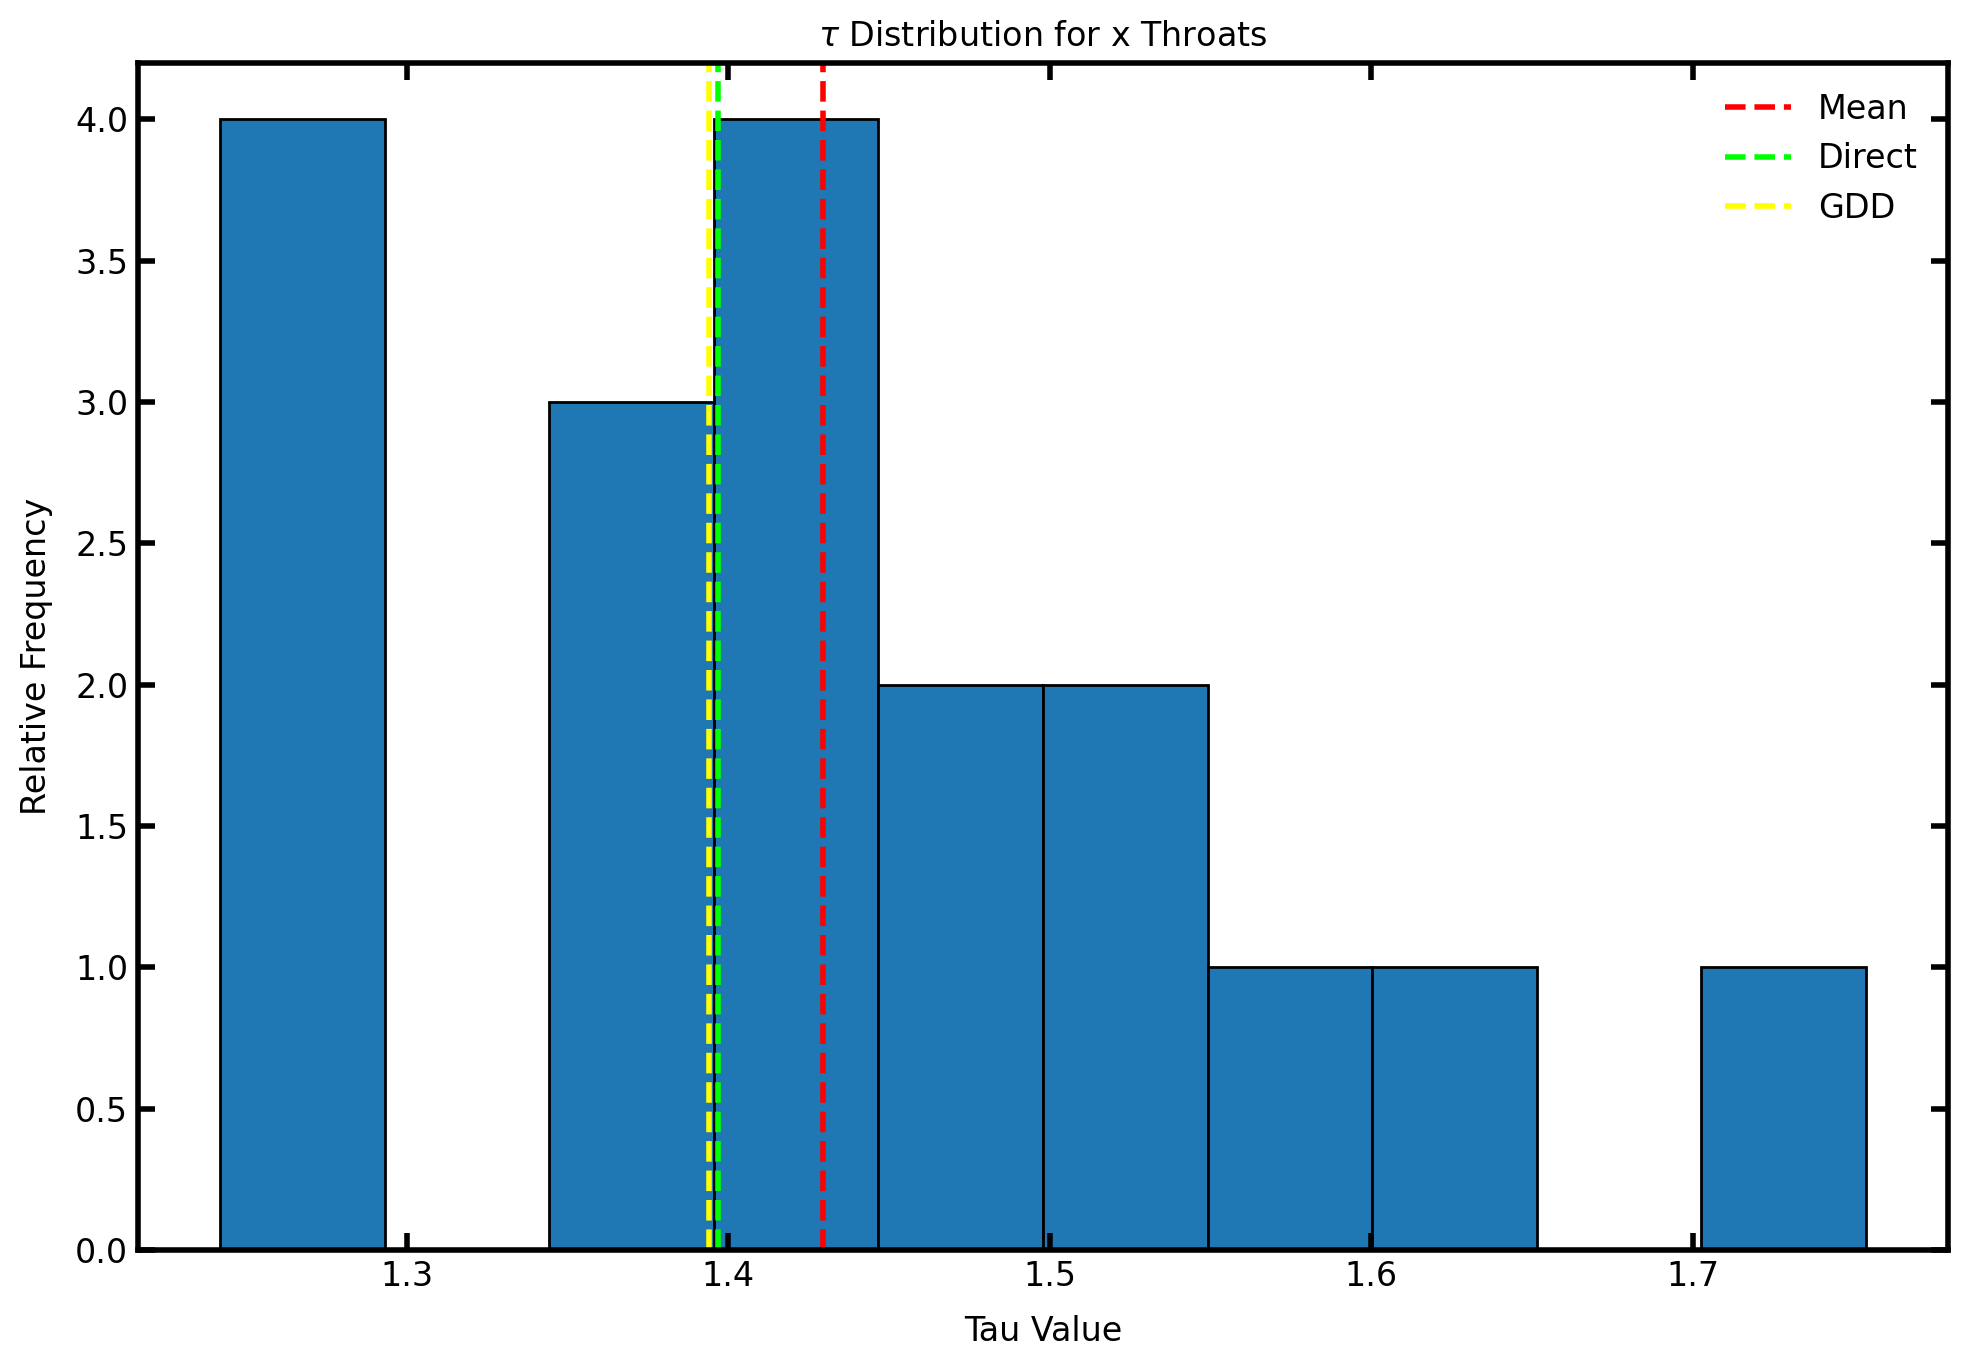

In [7]:
tau_values = np.array(out2.iloc[:, 1])
# the array of tau values is split up into thirds, where each third describes the throats in
# orthogonal directions of x, y, and z

fig, ax = plt.subplots(figsize=[10,7])
ax.set_title(r"$\tau$ Distribution for x Throats")
ax.hist(tau_values[:len(tau_values)//3], edgecolor='k')
ax.axvline(np.mean(tau_values[:len(tau_values)//3]), color='red', label='Mean', linestyle='--')
ax.axvline(tau_direct, color='lime', label='Direct', linestyle='--')
ax.axvline(tau_gdd, color='yellow', label='GDD', linestyle='--')

ax.set_xlabel(r'Tau Value')
ax.set_ylabel(r'Relative Frequency')
ax.legend();